## Ejecutar las simulaciones

In [1]:
schedule_names = ['fcfs', 'easy-backfill', 'sjf', 'sjf-with-optimisations']
nombres = ' '.join(schedule_names)

In [2]:
%%bash -s "$nombres"
cd ..
./scripts/run-simulations.sh $1

time="2023-10-08 19:10:24.681" level=info msg="Waiting for valid context" batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs" extracted socket endpoint="tcp://localhost:28000" ready timeout (seconds)=10
time="2023-10-08 19:10:24.684" level=info msg="Starting simulation" batsim cmdfile=output/fcfs/fcfs/cmd/batsim.bash batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs" batsim logfile=output/fcfs/fcfs/log/batsim.log scheduler cmdfile=output/fcfs/fcfs/cmd/sched.bash scheduler command="python -m pybatsim --options-file configs/fcfs.json schedulers/AllocOnly_sched.py" scheduler logfile (err)=output/fcfs/fcfs/log/sched.err.log scheduler logfile (out)=output/fcfs/fcfs/log/sched.out.log simulation timeout (seconds)=604800
time="2023-10-08 19:14:32.080" level=info msg="Simulation subprocess succeeded" command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs

## Imports

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

# Obteniendo los archivos a analizar

In [5]:
schedule_files = []
jobs_files = []
for folders in os.listdir('../output/'):
    for files in os.listdir('../output/' + folders):
        if files.endswith('_schedule.csv'):
            schedule_files.append(folders + "/" +  files)
        elif files.endswith('_jobs.csv'):
            jobs_files.append(folders + "/" + files)

schedule_files = [os.path.join('../output', str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/easy-backfill/easy-backfill_schedule.csv', '../output/fcfs/fcfs_schedule.csv', '../output/sjf-with-optimisations/sjf-with-optimisations_schedule.csv', '../output/sjf/sjf_schedule.csv']
['../output/easy-backfill/easy-backfill_jobs.csv', '../output/fcfs/fcfs_jobs.csv', '../output/sjf-with-optimisations/sjf-with-optimisations_jobs.csv', '../output/sjf/sjf_jobs.csv']


In [6]:
metrics = pd.DataFrame()
for file in schedule_files:
    print(file)
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[0]
        metrics = metrics.append(df)
    if schedule_name[1] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[1]
        metrics = metrics.append(df)
    print("----")
metrics.set_index('schedule', inplace=True)

../output/easy-backfill/easy-backfill_schedule.csv
----
../output/fcfs/fcfs_schedule.csv
----
../output/sjf-with-optimisations/sjf-with-optimisations_schedule.csv
----
../output/sjf/sjf_schedule.csv
----


In [7]:
jobsets = {}
for file in jobs_files:
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        print(f"{schedule_name[0]}")
        print("reading", file)
        jobsets[schedule_name[0]] = JobSet.from_csv(file)

easy-backfill
reading ../output/easy-backfill/easy-backfill_jobs.csv
fcfs
reading ../output/fcfs/fcfs_jobs.csv
sjf-with-optimisations
reading ../output/sjf-with-optimisations/sjf-with-optimisations_jobs.csv
sjf
reading ../output/sjf/sjf_jobs.csv


In [8]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [9]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [10]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})

In [11]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [12]:
metrics.T

,fcfs,easy-backfill,sjf,sjf-with-optimisations
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0
makespan,261070,260984,261168,261222
max_slowdown,67553.6,27746.2,46457.2,44362.6
max_turnaround_time,15984.5,14783.5,17841,17248.2
max_waiting_time,15979.5,14775.6,17830.3,17237.5
mean_slowdown,384.995,190.013,354.885,330.02
mean_turnaround_time,1993.14,1140.9,1920.6,1867.8
mean_waiting_time,1859.85,1007.75,1787.14,1734.02
nb_computing_machines,4,4,4,4


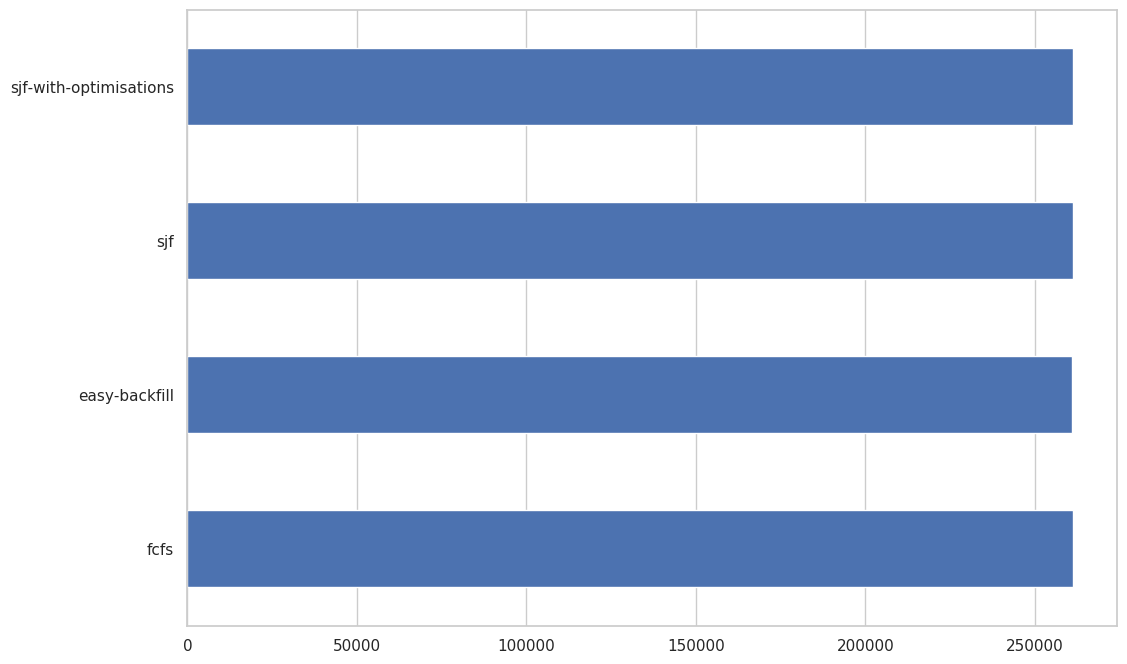

In [13]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

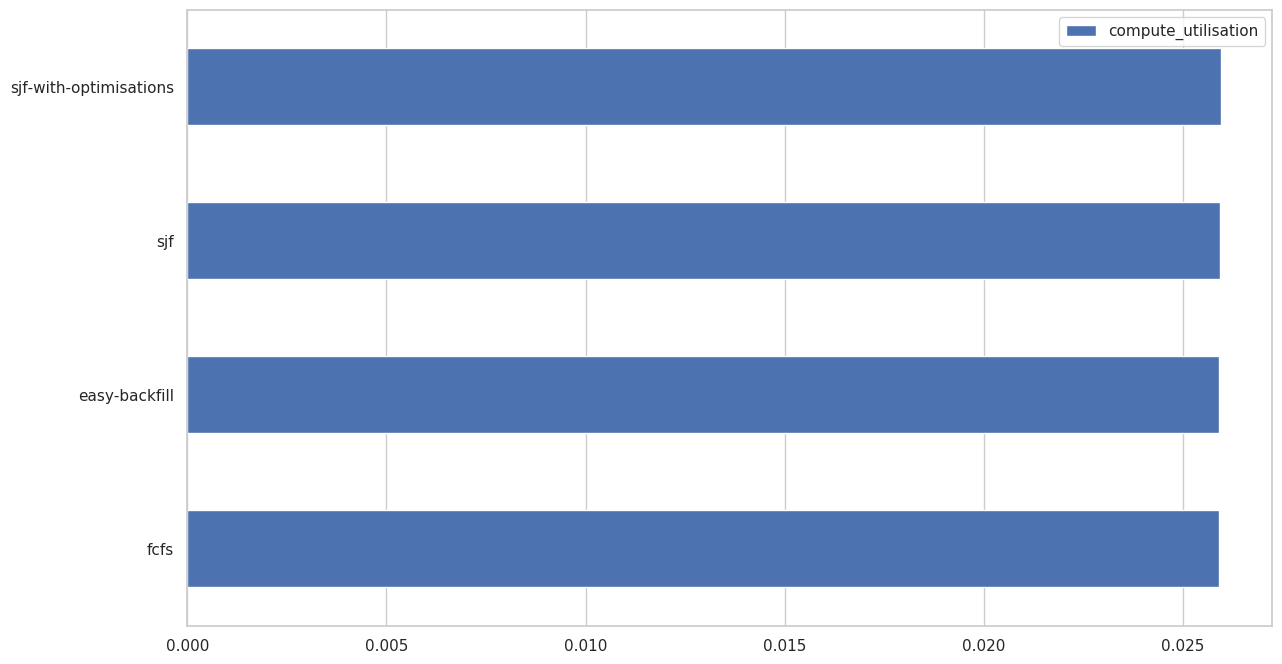

In [14]:
ax = metrics[['compute_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [15]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown
0,fcfs,0.000030,19.717915,1.000002
1,fcfs,19.719885,96.082207,1.258241
2,fcfs,96.084178,101.697788,18.116289
3,fcfs,101.699759,120.199439,6.497379
4,fcfs,19.719900,331.307441,1.063288
...,...,...,...,...
2445,sjf-with-optimisations,2009.821970,2664.204392,4.071326
2446,sjf-with-optimisations,2664.206363,2668.000402,703.208474
2447,sjf-with-optimisations,2668.002373,2685.628655,152.365011
2448,sjf-with-optimisations,2685.630626,2704.460185,143.628443


In [16]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,fcfs,easy-backfill,sjf,sjf-with-optimisations
count,2450.000000,2450.000000,2450.000000,2450.000000
mean,1859.854438,1007.751128,1787.141421,1734.020775
std,2456.555730,1608.219207,2633.121662,2579.359781
min,0.000030,0.000030,0.000030,0.000030
25%,225.395791,30.538780,91.465156,104.549358
50%,1042.528974,392.430024,831.401689,806.225975
75%,2363.795390,1262.565636,2296.503031,2214.458712
max,15979.455909,14775.611934,17830.260609,17237.522965


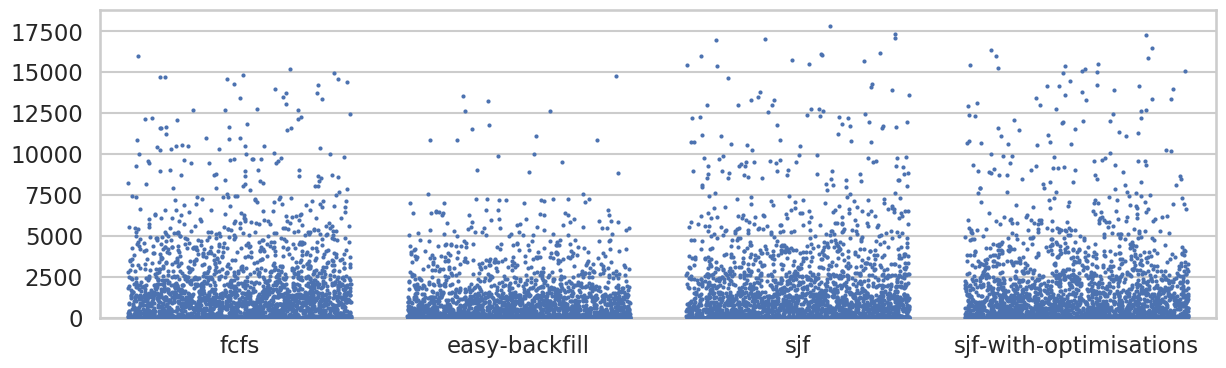

In [17]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/waiting-time_dist.pdf', bbox_inches='tight')

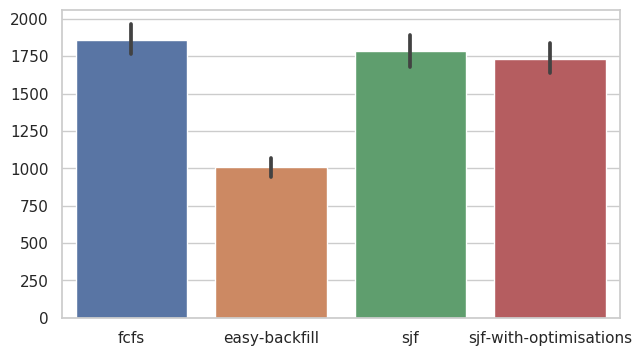

In [18]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=waiting_times, ax=ax)
fig.savefig('results/waiting-time_mean.pdf', bbox_inches='tight')

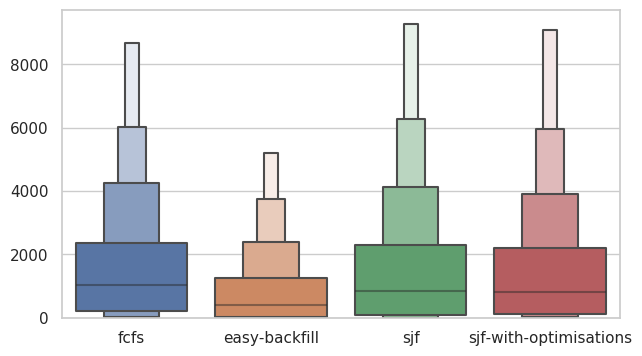

In [19]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/waiting-time_boxen.pdf', bbox_inches='tight')

In [20]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,fcfs,easy-backfill,sjf,sjf-with-optimisations
count,2450.000000,2450.000000,2450.000000,2450.000000
mean,1993.135828,1140.903382,1920.603502,1867.802765
std,2474.493959,1666.079415,2651.941708,2597.719346
min,0.217383,0.217368,0.217383,0.217368
25%,368.236092,70.964799,223.361942,215.832233
50%,1225.993548,521.420902,992.279873,987.792617
75%,2535.583693,1474.075469,2499.833054,2367.586881
max,15984.460196,14783.485544,17840.972814,17248.235170


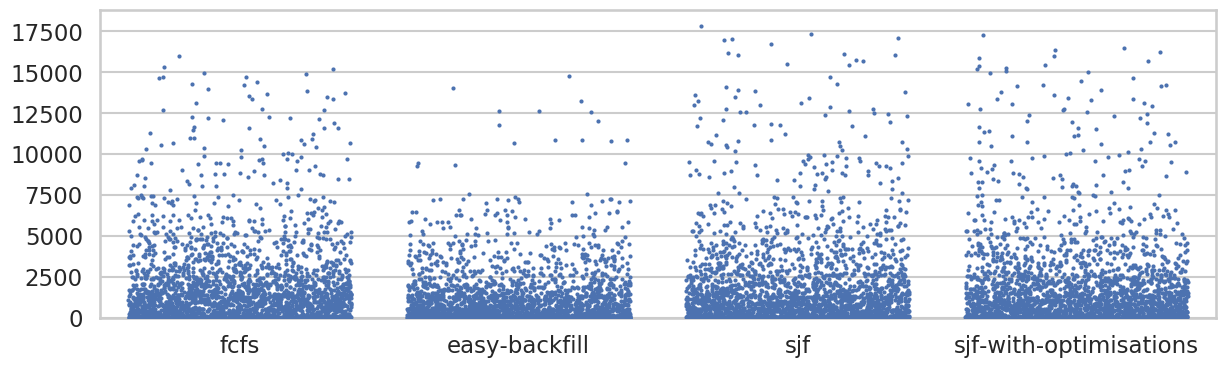

In [21]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
#     ax.set_ylim(top=2.5*10**6)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/turnaround-time_dist.pdf', bbox_inches='tight')

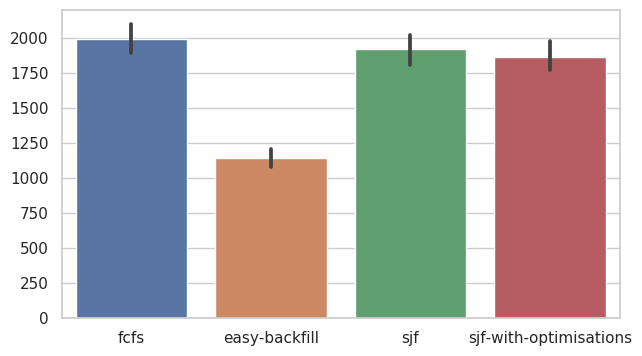

In [22]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=turnaround_times, ax=ax)
fig.savefig('results/turnaround-time_mean.pdf', bbox_inches='tight')

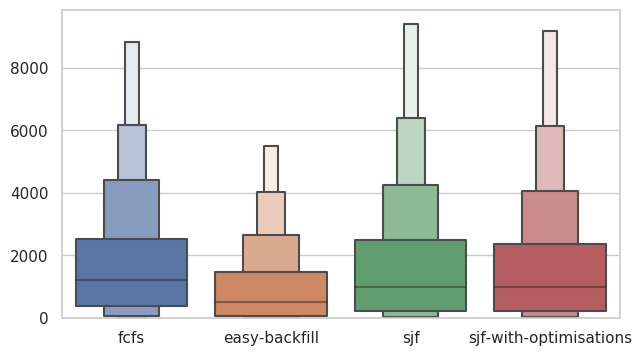

In [23]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/turnaround-time_boxen.pdf', bbox_inches='tight')

In [24]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,fcfs,easy-backfill,sjf,sjf-with-optimisations
count,2450.000000,2450.000000,2450.000000,2450.000000
mean,384.995201,190.012579,354.885370,330.019987
std,2012.460374,1084.798295,1761.091783,1531.428075
min,1.000000,1.000000,1.000000,1.000000
25%,3.999131,2.137837,2.709113,3.164334
50%,38.329465,9.657220,25.929375,25.299644
75%,205.894541,75.423721,168.433726,158.380210
max,67553.551748,27746.150368,46457.158793,44362.581022


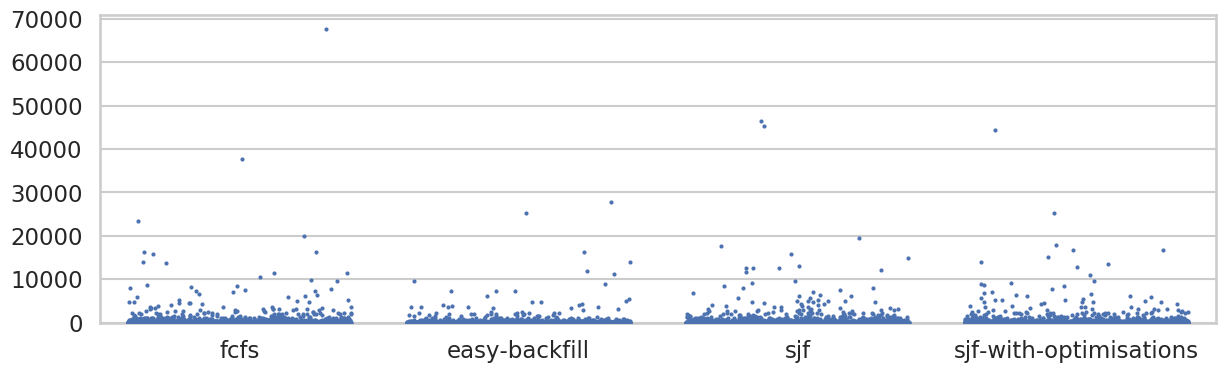

In [25]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/slowdown_dist.pdf', bbox_inches='tight')

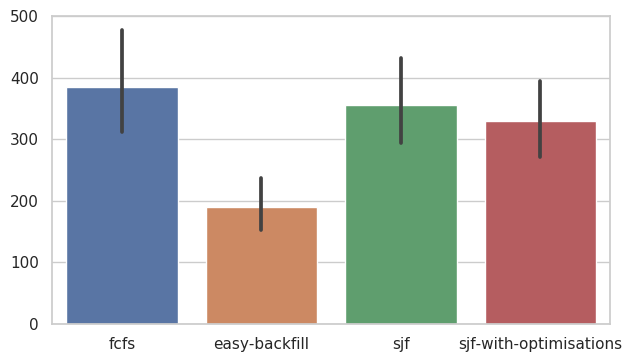

In [26]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=slowdown, ax=ax)
fig.savefig('results/slowdown_mean.pdf', bbox_inches='tight')

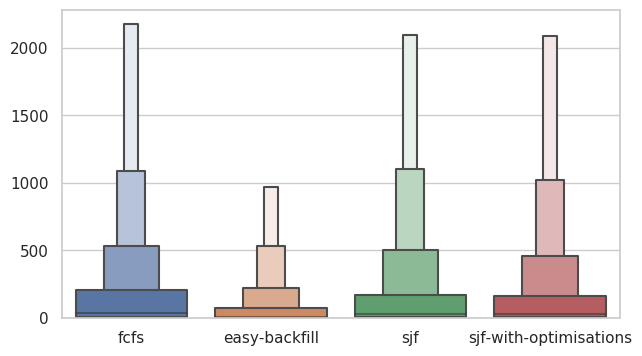

In [27]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/slowdown_boxen.pdf', bbox_inches='tight')

In [28]:
# FCFS

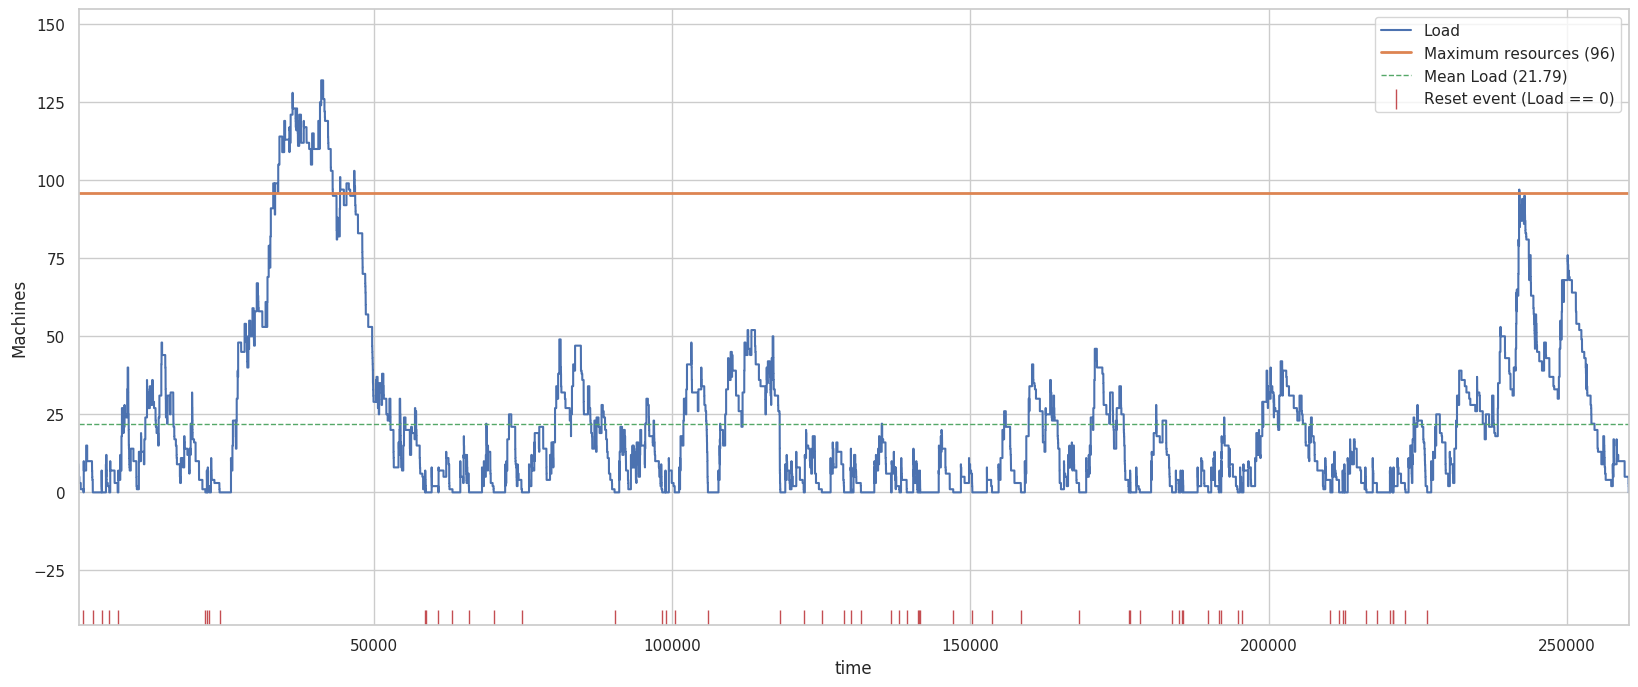

In [29]:
fig, ax = plt.subplots(figsize=(20,8))
evalys.visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)

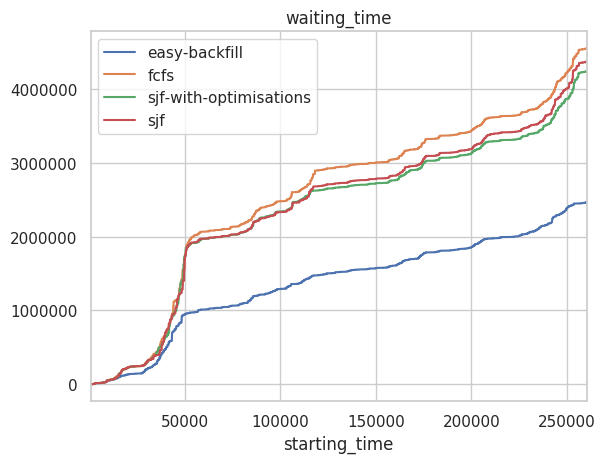

In [30]:
evalys.visu.legacy.plot_series('waiting_time', jobsets)